Load and format data

In [1]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *

In [2]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [3]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/scripts/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from vmpv.mat object
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')

# Extract session time and position bins
session_data = np.array(pv.get('sessionTimeC'))
session_data = session_data[:,1:] # discard first row containing '0' timestamp
timepoints, pos_bins = session_data[0,:], session_data[1,:]

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)

In [4]:
# Re-bin timepoints and position bin data into 100ms bins
# timepoints, pos_bins = rebin_data(timepoints, pos_bins, 0.05)

# Get start/end indices of all trials in the session
trial_indices = get_trial_indices(session_data)

# Convert position bins to coordinates, spike timestamps to spiketrains
pos_coords = pos_bins_to_coords(pos_bins)
spiketrains = spike_trains_from_times(spike_times, timepoints)

# Split data into individual trials
timepoints = split_by_trials(timepoints, trial_indices)
pos_coords = split_by_trials(pos_coords, trial_indices)
spiketrains = split_by_trials(spiketrains, trial_indices)

In [5]:
# Check number of time bins and bin intervals per trial
time_bins_per_trial, bin_intervals = list(), list()
for trial in timepoints:
    time_bins_per_trial.append(trial.shape[0])
    bin_intervals.append(np.diff(trial))

Preprocess data and split into training/testing sets

In [6]:
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho
from Neural_Decoding.decoders import NaiveBayesDecoder

/Users/jcheng/miniconda3/envs/decoding/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
# How many time bins before/concurrent/after to use for decoding
bins_before = 4
bins_current = 1
bins_after = 5

#Number of bins to sum spikes over
N_bins = bins_before + bins_current + bins_after

In [8]:
# Total number of trials across the session
N_trials = len(timepoints)

# Split data into training and testing sets, and combine trials in the same set
# First half of session for training, second half of session for testing
X, y = spiketrains, pos_coords
X_train, X_test = combine_trials(X[:int(N_trials//2)]), combine_trials(X[int(N_trials//2):])
y_train, y_test = combine_trials(y[:int(N_trials//2)]), combine_trials(y[int(N_trials//2):])

In [9]:
# Initialize matrices for neural data in Naive bayes format
N_cells = X_train.shape[1]
X_b_train = np.empty([X_train.shape[0]-N_bins+1,N_cells])
X_b_test = np.empty([X_test.shape[0]-N_bins+1,N_cells])

# For all neurons, within all the bins being used, get the total number of spikes (sum across all those bins)
for i in range(N_cells):
    # Convolving w/ ones is a sum across those N bins
    X_b_train[:,i] = N_bins * np.convolve(X_train[:,i], np.ones((N_bins,))/N_bins, mode='valid') 
    X_b_test[:,i] = N_bins * np.convolve(X_test[:,i], np.ones((N_bins,))/N_bins, mode='valid')

# Convert data type back to int
X_b_train = X_b_train.astype(int)
X_b_test = X_b_test.astype(int)

# # Set all 0s in spike count data to some small number eps
# eps = 0.001
# X_b_train[np.where(X_b_train==0)] = eps
# X_b_test[np.where(X_b_test==0)] = eps

# Make y's aligned w/ X's
# e.g. we have to remove the first y if we are using 1 bin before, and have to remove the last y if we are using 1 bin after
if bins_before > 0 and bins_after > 0:
    y_train = y_train[bins_before:-bins_after,:]
    y_test = y_test[bins_before:-bins_after,:]
    
if bins_before > 0 and bins_after == 0:
    y_train = y_train[bins_before:,:]
    y_test = y_test[bins_before:,:]

In [10]:
# Check spike counts per cell across entire session
spiketrains_counts = [0 for cell in spike_times]
for i in range(len(spiketrains_counts)):
    for trial in spiketrains:
        spiketrains_counts[i] += np.sum(trial[:,i])
total_timebins = sum(trial.shape[0] for trial in X)
firing_freqs = list(map(lambda x: x / total_timebins, spiketrains_counts))

print(spiketrains_counts)
print(firing_freqs)

[4275, 28657, 1465, 308, 3822, 11263, 23380, 18840, 113591, 5450, 46238, 196, 171]
[0.01590354453736496, 0.10660769024731406, 0.005449986607541442, 0.0011457992321657093, 0.014218326835510848, 0.04189979464896878, 0.0869765780780334, 0.07008719978572066, 0.4225729888991399, 0.020274694205529596, 0.17201124966518855, 0.0007291449659236332, 0.0006361417814945984]


Run decoder and get metrics

In [11]:
# Declare model

# The parameter "encoding_model" can either be linear or quadratic, although additional encoding models could later be added.

# The parameter "res" is the number of bins used (resolution) for decoding predictions
# So if res = 100, we create a 100 x 100 grid going from the minimum to maximum of the output variables (x and y positions)
# The prediction the decoder makes will be a value on that grid

model = NaiveBayesDecoder(encoding_model='quadratic', res=40)

# Fit model
model.fit(X_b_train, y_train)

In [12]:
# Get predictions
y_test_pred = model.predict(X_b_test, y_test)

In [13]:
# Get metric of fit
R2 = get_R2(y_test, y_test_pred)
print(R2)

[-3.53997667 -4.21613314]


In [14]:
# Sanity check
y_train_pred = model.predict(X_b_train, y_train)
R2_train = get_R2(y_train, y_train_pred)
print(R2_train)

[-3.77918866 -4.01731794]


View prediction results

In [15]:
import matplotlib.pyplot as plt

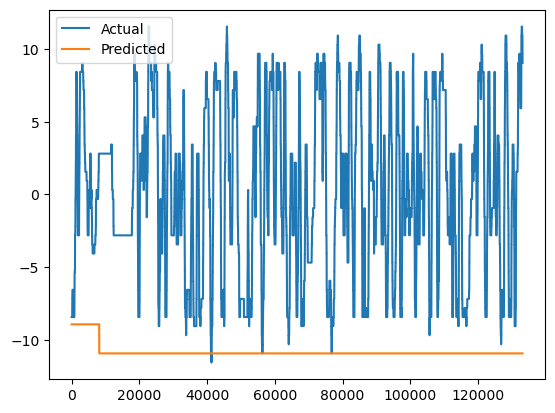

In [16]:
# Plot for x-coordinates
plt.figure('x-coords')
plt.plot(y_test[:,0], label='Actual')
plt.plot(y_test_pred[:,0], label='Predicted')
plt.legend()

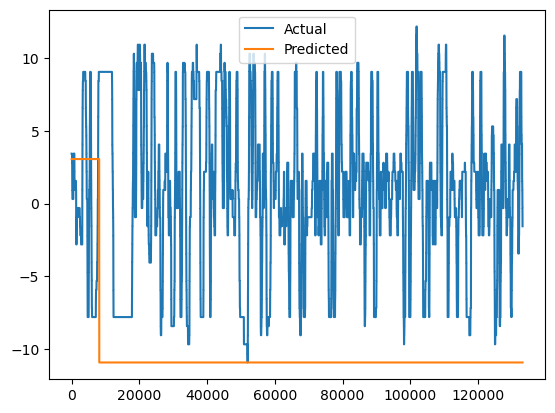

In [17]:
# Plot for y-coordinates
plt.figure('y-coords')
plt.plot(y_test[:,1], label='Actual')
plt.plot(y_test_pred[:,1], label='Predicted')
plt.legend()

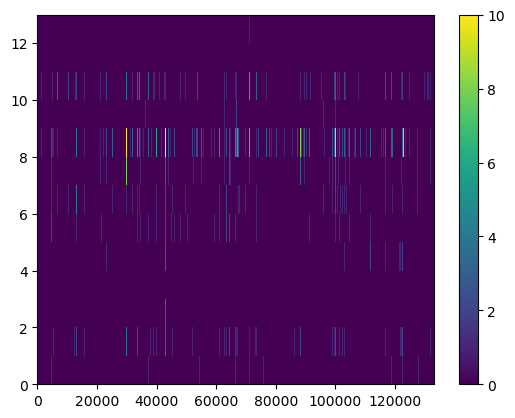

In [18]:
# Plot heatmap of neuron activity
plt.figure('Firing rates')
plt.pcolormesh(X_test.T, cmap='viridis', vmin=0, vmax=10)
plt.colorbar()

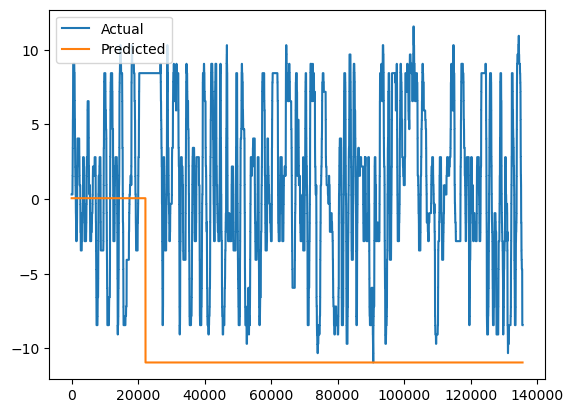

In [19]:
# Plot for x-coordinates
plt.figure('x-coords')
plt.plot(y_train[:,0], label='Actual')
plt.plot(y_train_pred[:,0], label='Predicted')
plt.legend()

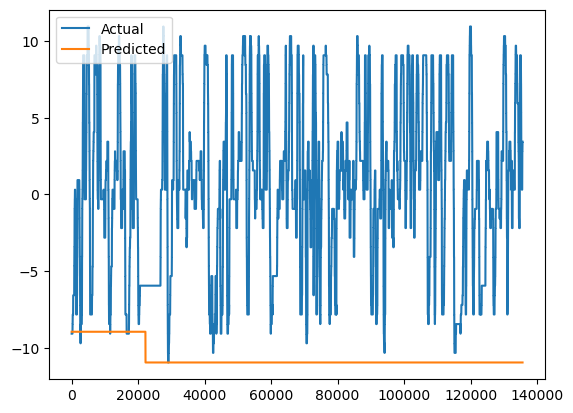

In [20]:
# Plot for y-coordinates
plt.figure('y-coords')
plt.plot(y_train[:,1], label='Actual')
plt.plot(y_train_pred[:,1], label='Predicted')
plt.legend()

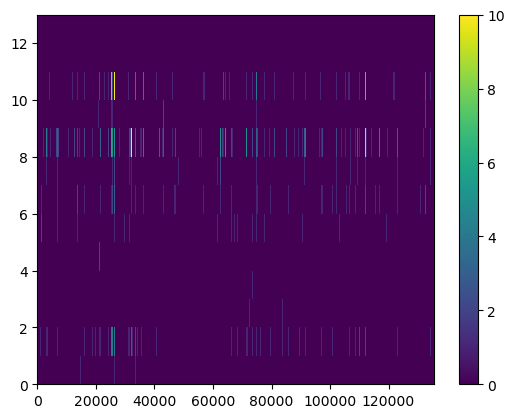

In [21]:
# Plot heatmap of neuron activity
plt.figure('Firing rates')
plt.pcolormesh(X_train.T, cmap='viridis', vmin=0, vmax=10)
plt.colorbar()